In [2]:
import csv
import os
import numpy as np
import pandas as pd
import scipy.io
import sys
from tkinter.filedialog import askopenfilename
from tkinter import *
import matplotlib.pyplot as plt

In [3]:
def precision(ranking,rGT,num):
    images = ranking["Id_image"][:num]
    relevantes = 0
    for image in images:
        relevantes = relevantes + int(rGT[rGT["Id_Imagen"]==image]["Relevant"])
    prec = relevantes/num
    
    return prec

In [30]:
rGT[rGT["Id_Imagen"]==16328028734]["Relevant"]

287    1
Name: Relevant, dtype: int64

In [27]:
for i in df_res_q["Id_image"][:5]:
    print(i)

16328028734
530401587
5684540177
5694615172
11651608396


In [7]:
#Esta no se usa
def exhaustividad(ranking,rGT,num):
    images = ranking["Id_image"][:num]
    relevantes_total = rGT["Relevant"].sum()
    relevantes = 0
    for image in images:
        relevantes = relevantes + int(rGT[rGT["Id_Imagen"]==int(image)]["Relevant"])
    exhaustividad = relevantes/relevantes_total
    
    return exhaustividad

In [8]:
def F1_score(ranking,rGT,dGT,num):
    prec = precision(ranking,rGT,num)
    recall = cluster_recall(ranking,dGT,num)
    F1 = 2*prec*recall/(prec+recall)
    
    return F1

In [9]:
def cluster_recall(ranking,dGT,num):
    images = ranking["Id_image"][:num]
    total_clusters = len(np.unique(dGT["Cluster"]))
    clust_bool = np.zeros(total_clusters)
    for image in images:
        try:
            cluster = int(dGT[dGT["Id_Imagen"]==int(image)]["Cluster"])
            if clust_bool[cluster-1] == 0:
                clust_bool[cluster-1] = 1
        except:
            pass
    clusters_ranking = clust_bool.sum()
    CRn = clusters_ranking/total_clusters
    
    return CRn

In [10]:
def generar_excel(filesheet,medidas,df_names,df_ids,run,resul_name):
    try:
        os.remove(filesheet)
    except:
        pass
    writer = pd.ExcelWriter(filesheet,engine='xlsxwriter')   
    workbook=writer.book
    worksheet=workbook.add_worksheet(run)
    writer.sheets[run] = worksheet
    
    #Añadimos el tipo de run
    worksheet.write(0,0,"---------------")
    worksheet.write(1,0,"Run Name")
    worksheet.write(2,0,"---------------")
    worksheet.write(1,1,resul_name)
    
    #Añadimos los average de cada medida para 20 al principio de la hoja
    averages_index = ["Average P@20","Average CR@20","Average F1@20"]
    averages = pd.DataFrame([medidas["P@20"].mean(),medidas["CR@20"].mean(),medidas["F1@20"].mean()],index=averages_index)
    averages.to_excel(writer,sheet_name=run,startrow=3 , startcol=0,index=True,header=False)
    
    
    #Añadimos los dataframes
    df_ids.to_excel(writer,sheet_name=run,startrow=8 , startcol=0,index=False) 
    df_names.to_excel(writer,sheet_name=run,startrow=8 , startcol=1,index=False) 
    medidas.to_excel(writer,sheet_name=run,startrow=8, startcol=2,index=False)
    
    #Añadimos las medias de cada medida debajo del dataframe
    medias = pd.DataFrame(medidas.mean()).T
    medias.to_excel(writer,sheet_name=run,startrow=8+medidas.shape[0]+2, startcol=2,index=False)
    
    writer.save()

In [11]:
#Primero de todo abrimos y leemos el fichero con los resultados

In [12]:
seleccion_fichero = True

In [13]:
if seleccion_fichero:

    resul_file = "unassigned"

    def openFile():
        global resul_file
        resul_file = askopenfilename()
        root.destroy()

    if __name__ == '__main__':

        root = Tk()
        Button(root, text='File Open', command = openFile).pack(fill=X)
        mainloop()

        print ("Archivo seleccionado: ",resul_file)
        resul_name = os.path.split(resul_file)[-1]
else:
    resul_path = r"D:\MediaEval2016\Dades\resultados"
    resul_name = "run3_UNED_UV_ini_71_5primerasFlicker_v2.txt" #AQUI SE CAMBIA EL ARCHIVO DE EVALUACION

    resul_file = os.path.join(resul_path,resul_name)

Archivo seleccionado:  D:/MediaEval2016/Dades/resultados/RESULTADOS DEFINITVOS/Test/run3/run3_UNED_UV_ini_71_ClustersVisuales_20_AlexNet.txt


In [14]:
df_res = pd.read_csv(resul_file,sep=" ",header=None,names=["Query","Iter","Id_image","Rank Position","Probability","Run type"])

In [15]:
#Preparamos las rutas de los ficheros de GT

In [16]:
dGT_path = r"D:\MediaEval2016\Dades\images\gt\dGT"
rGT_path = r"D:\MediaEval2016\Dades\images\gt\rGT"

In [17]:
#Abrimos el fichero que asocie cada numero de query con su nombre

In [18]:
if "ini_1_" in resul_file:
    inicio=1
    final=70
    print("Abrimos devset")
    Topics_names  = scipy.io.loadmat("DevSetTopics.mat")
    
    Topics_names_list=[]
    for i in range(len(Topics_names["DevSetTopics"])):
        Topics_names_list.append([Topics_names["DevSetTopics"][i][0][0][0],Topics_names["DevSetTopics"][i][1][0]])
        
elif "ini_71_" in resul_file:
    inicio=71
    final=135
    print("Abrimos testset")
    Topics_names  = scipy.io.loadmat("TestSetTopics.mat")
    
    Topics_names_list=[]
    for i in range(len(Topics_names["TestSetTopics"])):
        Topics_names_list.append([Topics_names["TestSetTopics"][i][0][0][0],Topics_names["TestSetTopics"][i][1][0]])
    
else:
    print("No esta preparado el set")

Abrimos testset


In [19]:
#Recorremos cada topic del dataframe y calculamos las medidas Precision,Cluster Recall y F1

In [34]:
precisiones = []
diversidad = []
F1 = []
index = []
for i in range(inicio,final+1):
    if i==124:
        continue
    #print(f"\nTopic {i}\n")
    df_res_q = df_res[df_res["Query"]==i]
    
    dGT_file = os.path.join(dGT_path,f"{Topics_names_list[i-inicio][1]} dGT.txt")
    
    
    dGT = pd.read_csv(dGT_file,sep=",",header=None,names=["Id_Imagen","Cluster"])
    
    rGT_file = os.path.join(rGT_path,f"{Topics_names_list[i-inicio][1]} rGT.txt")
    rGT = pd.read_csv(rGT_file,sep=",",header=None,names=["Id_Imagen","Relevant"])
    
    print(rGT_file)
    print(df_res_q)
    break
    precisiones_topic = []
    cluster_rec = []
    f1 = []
    for n in [5,10,20,30,40,50]:
        precisiones_topic.append(precision(ranking=df_res_q,rGT=rGT,num=n))
        cluster_rec.append(cluster_recall(ranking=df_res_q,dGT=dGT,num=n))
        f1.append(F1_score(ranking=df_res_q,rGT=rGT,dGT=dGT,num=n))
        
    index.append(i)
    precisiones.append(precisiones_topic)
    diversidad.append(cluster_rec)
    F1.append(f1)

precisiones = pd.DataFrame(np.array(precisiones),columns=["P@5","P@10","P@20","P@30","P@40","P@50"],index=index)
diversidad  =  pd.DataFrame(np.array(diversidad) ,columns=["CR@5","CR@10","CR@20","CR@30","CR@40","CR@50"],index=index)
F1    =  pd.DataFrame(np.array(F1) ,columns=["F1@5","F1@10","F1@20","F1@30","F1@40","F1@50"],index=index)

precisiones[np.isnan(precisiones)] = 0
diversidad[np.isnan(diversidad)] = 0
F1[np.isnan(F1)] = 0

D:\MediaEval2016\Dades\images\gt\rGT\accordion_player rGT.txt
    Query  Iter     Id_image  Rank Position  Probability         Run type
0      71     0  16023880894              0         1.00  run3_multimedia
1      71     0   5740253391              1         0.99  run3_multimedia
2      71     0   6877697425              2         0.98  run3_multimedia
3      71     0   8692618114              3         0.97  run3_multimedia
4      71     0   7896290218              4         0.96  run3_multimedia
5      71     0   3202741397              5         0.95  run3_multimedia
6      71     0   4916680233              6         0.94  run3_multimedia
7      71     0   5002423299              7         0.93  run3_multimedia
8      71     0   4466673605              8         0.92  run3_multimedia
9      71     0   8053180860              9         0.91  run3_multimedia
10     71     0  22731621012             10         0.90  run3_multimedia
11     71     0  13119160923             11       

ValueError: Empty data passed with indices specified.

In [21]:
[precisiones["P@20"].mean(),diversidad["CR@20"].mean(),F1["F1@20"].mean()]

[0.6179687499999998, 0.4272723574908372, 0.48184550729532494]

In [22]:
medidas = pd.concat([precisiones,diversidad,F1],axis=1)
medidas

,P@5,P@10,P@20,P@30,P@40,P@50,CR@5,CR@10,CR@20,CR@30,CR@40,CR@50,F1@5,F1@10,F1@20,F1@30,F1@40,F1@50
71,1.0,1.0,0.95,0.900000,0.925,0.88,0.222222,0.277778,0.500000,0.500000,0.500000,0.500000,0.363636,0.434783,0.655172,0.642857,0.649123,0.637681
72,1.0,1.0,1.00,1.000000,1.000,1.00,0.214286,0.285714,0.571429,0.571429,0.571429,0.571429,0.352941,0.444444,0.727273,0.727273,0.727273,0.727273
73,0.8,0.8,0.80,0.733333,0.800,0.78,0.200000,0.350000,0.450000,0.500000,0.550000,0.600000,0.320000,0.486957,0.576000,0.594595,0.651852,0.678261
74,1.0,1.0,1.00,0.866667,0.900,0.90,0.200000,0.240000,0.400000,0.440000,0.560000,0.640000,0.333333,0.387097,0.571429,0.583673,0.690411,0.748052
75,0.6,0.5,0.45,0.466667,0.525,0.50,0.272727,0.363636,0.454545,0.545455,0.545455,0.636364,0.375000,0.421053,0.452261,0.502994,0.535032,0.560000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.0,0.1,0.15,0.133333,0.100,0.08,0.000000,0.111111,0.222222,0.333333,0.333333,0.333333,0.000000,0.105263,0.179104,0.190476,0.153846,0.129032
132,0.8,0.8,0.90,0.933333,0.925,0.94,0.166667,0.291667,0.458333,0.541667,0.541667,0.541667,0.275862,0.427481,0.607362,0.685499,0.683239,0.687289
133,1.0,1.0,1.00,1.000000,1.000,1.00,0.160000,0.280000,0.520000,0.600000,0.720000,0.800000,0.275862,0.437500,0.684211,0.750000,0.837209,0.888889
134,0.2,0.4,0.55,0.433333,0.400,0.40,0.055556,0.222222,0.444444,0.555556,0.611111,0.722222,0.086957,0.285714,0.491620,0.486891,0.483516,0.514851


In [19]:
#Como ocurre un error al transformar Topic_Names_List a un dataframe tengo que hacerlo a trozos
df_names = pd.DataFrame(Topics_names_list,columns=["Query ID","Location Name"])
if inicio==71:
    df_names = df_names.loc[df_names["Location Name"]!="speed_ice_skating"]
df_names = df_names.loc[:,["Location Name"]]
df_ids = pd.DataFrame(index,columns=["Query ID"])

In [20]:
#Procedemos a la creación del archivo en excel xlsx

In [123]:
run = df_res["Run type"][0]
filesheet = rf'D:\MediaEval2016\Dades\resultados\excels_definitivos\{resul_name[:-4]}.xlsx'

In [124]:
generar_excel(filesheet,medidas,df_names,df_ids,run,resul_name)

In [24]:
def get_rGT(topic):
    rGT_path = r"D:\MediaEval2016\Dades\images\gt\rGT"
    rGT_file = os.path.join(rGT_path,topic_2name(topic)+" rGT.txt")
    rGT = pd.read_csv(rGT_file,sep=",",header=None,names=["Id_Imagen","Relevant"])
    return rGT
def topic_2name(topic):
    names_path = r'C:\Users\alexc\OneDrive\Documentos\MATEMATICAS\TFG\codigoMediaEval2016\codigoMediaEval2016'
    Dev_Topics_names  = scipy.io.loadmat(os.path.join(names_path,"DevSetTopics.mat"))
    Test_Topics_names = scipy.io.loadmat(os.path.join(names_path,"TestSetTopics.mat"))
    Topics_names=[]
    for i in range(len(Dev_Topics_names["DevSetTopics"])):
        Topics_names.append([Dev_Topics_names["DevSetTopics"][i][0][0][0],Dev_Topics_names["DevSetTopics"][i][1][0]])
    for i in range(len(Test_Topics_names["TestSetTopics"])):
        Topics_names.append([Test_Topics_names["TestSetTopics"][i][0][0][0],Test_Topics_names["TestSetTopics"][i][1][0]])
        
    for i in range(len(Topics_names)):
        if Topics_names[i][0]==topic:
            topic_name = Topics_names[i][1]
            break
            
    return topic_name

In [109]:
num_clusters = 20

carpetas = []
carpetas_raw = ["5primeras_st_no_diversity","5primeras_st_ClusterVisual","5primeras_Flickr_no_diversity","5primeras_Flickr_ClusterVisual"]
for i in range(len(carpetas_raw)):
    carpetas.append(carpetas_raw[i]+f"_{num_clusters}")
    
    
aciertos=[]
for index,carpeta in enumerate(carpetas):
    aux=[]
    #VAMOS A ESTUDIAR CON EL MÉTODO DE 5 PRIMERAS IMÁGENES CUANTAS SON RELEVANTES DE LAS POSITIVAS
    print(index,carpeta)
    for top in [x for x in range(1,136) if x != 124]:
        rGT = get_rGT(top)
        relevantes = 0
        for name in os.listdir(os.path.join(r'D:\MediaEval2016\Dades\images',"positivas",carpeta,f"topic{top}")):
            name = name.replace(".jpg","")
            relevantes +=(rGT[rGT["Id_Imagen"]==int(name)]["Relevant"]).sum()
        #print(f"Topic {top}: [{relevantes}/5]")
        aux.append(relevantes)
    aciertos.append(aux)

0 5primeras_st_no_diversity_20
1 5primeras_st_ClusterVisual_20
2 5primeras_Flickr_no_diversity_20
3 5primeras_Flickr_ClusterVisual_20


In [110]:
aciertos[1].insert(123,-1)

Estudio las diferentes medidas para los diferentes números de imágenes positivas del entrenamiento

In [111]:
topics = [[] for _ in range(6)]
for num in [0,1,2,3,4,5]:
    for i in [x for x in range(71,135) if x != 124]:
        if aciertos[1][i]==num:
            topics[num].append(i+1)

In [112]:
for num in [0,1,2,3,4,5]:
    print(f"\n\nRecuperadas [{num}/5]")
    for med in ["P@20","CR@20","F1@20"]:
        print(med,medidas[med][topics[num]].mean())



Recuperadas [0/5]
P@20 0.21000000000000002
CR@20 0.21525627794977642
F1@20 0.20168442658851315


Recuperadas [1/5]
P@20 0.5625
CR@20 0.3527472527472527
F1@20 0.404863547265759


Recuperadas [2/5]
P@20 0.4055555555555556
CR@20 0.3759412279883294
F1@20 0.3709640111238325


Recuperadas [3/5]
P@20 0.4928571428571429
CR@20 0.4034906105844321
F1@20 0.42997955787376263


Recuperadas [4/5]
P@20 0.6708333333333333
CR@20 0.4994062789921923
F1@20 0.5571554518479295


Recuperadas [5/5]
P@20 0.9187500000000001
CR@20 0.4343543280549859
F1@20 0.578083073674945


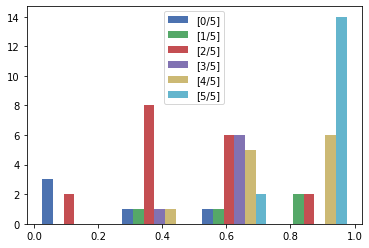

In [143]:
#Grafica
bins = np.linspace(0, 1, 5)
plt.style.use('seaborn-deep')
prec = [medidas["P@20"][topics[x]] for x in [0,1,2,3,4,5]]
label = [f"[{x}/5]" for x in [0,1,2,3,4,5]]

plt.hist(prec, bins, label=label)

plt.legend(loc='upper center')
plt.show()